# Bitcoin Prediction using Stocker

Stocker ("stock explorer") is a Python-based toolkit adjusted for Bitcoin price prediction. It is built on the crypto_signal app for bitcoin data, the prophet library from Facebook for additive models, numpy and pandas for data manipulation, and matplotlib for visualization. 

This notebook will document some of the basic capabilities of Stocker for prediction. To see the original code for Stocker, check out stocker.py and to see a notebook with analysis examples, look at the [Stocker Analysis Usage notebook](https://github.com/WillKoehrsen/Data-Analysis/blob/master/stocker/Stocker%20Analysis%20Usage.ipynb). 

In [1]:
#Note: before launching Jupyter lab, need to export: export DJANGO_SETTINGS_MODULE=crypto_signal.settings
import django
django.setup()# Matplotlib for plotting in the notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

## Import the Stocker Class

In [2]:
from crypto_track.stocker import Stocker

### Instantiate a Stocker object 

We will be looking at Bitcoin data throughout this example. To retrieve the data, we pass the ticker to the stocker class and assign it to a variable. 

In [3]:
bitcoin = Stocker('BTC')

BTC Stocker Initialized. Data covers 2013-01-14 to 2018-12-02.


In [4]:
start = '2017-01-01'
end = '2018-12-02'
bitcoin.training_years=6

/Users/lauramay/Documents/GitHub/crypto_signal/crypto_signal/crypto_track/stocker.py:620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_pred_increase['pred_profit'] = prediction_profit


You played the stock market in BTC from 2017-01-01 to 2018-12-02 with 100 shares.

When the model predicted an increase, the price increased 63.76% of the time.
When the model predicted a  decrease, the price decreased  42.96% of the time.

The total profit using the Prophet model = $916320.62.
The Buy and Hold strategy profit =         $1306669.44.

Thanks for playing the stock market!



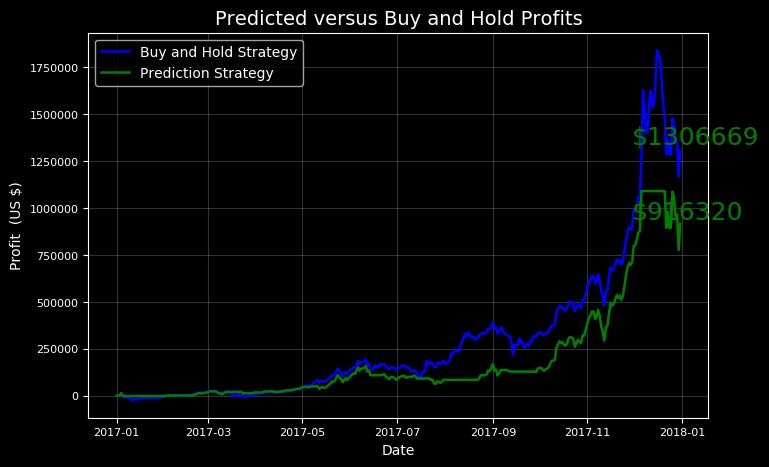

In [5]:
bitcoin.evaluate_prediction(start_date=start, end_date=end, nshares=100)

The Stocker object has a number of attributes and methods we can use for analysis and prediction. The main methods we will use in this notebook are `Stocker.create_prophet_model(), Stocker.changepoint_prior_analysis(), Stocker.changepoint_prior_validation(), Stocker.evaluate_prediction(),` and `Stocker.predict_future()`.

The most critical attributes for a forecast are `Stocker.changepoint_prior_scale, Stocker.training_years`, and the seasonalities included in the model. 

### Basic Plot of Stock History

We have a little over 5 years of bitcoin price history. Let's see what that looks like in its entirety.

Maximum period_close = 19409.63 on 2017-12-16.
Minimum period_close = 14.53 on 2013-01-14.
Current period_close = 4133.07 on 2018-12-02.



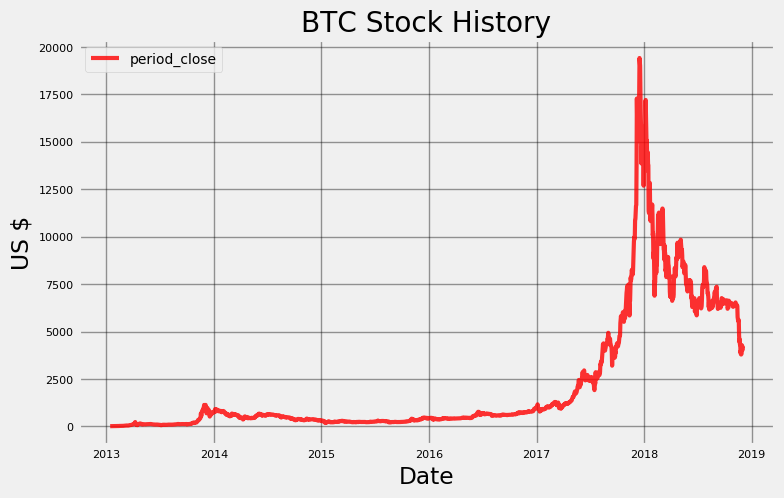

In [6]:
bitcoin.plot_stock()

Looks predictable right? 

### Plot of Daily Changes

Maximum Daily Change = 3498.87 on 2017-12-07.
Minimum Daily Change = -2457.83 on 2018-01-16.
Current Daily Change = -53.20 on 2018-12-02.



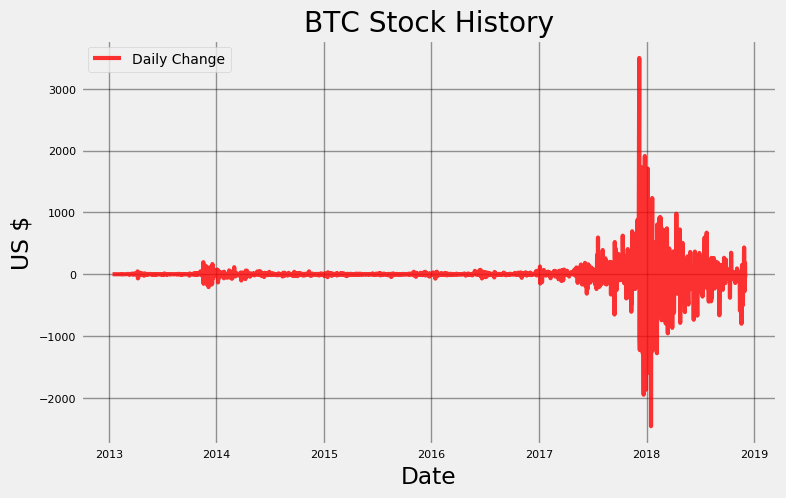

In [7]:
bitcoin.plot_stock(stats=['Daily Change'])

## Examine Trends/Patterns

We can create a basic model (with no predictions) trained on the past 3 years of data to inspect any trends and patterns in the data. 

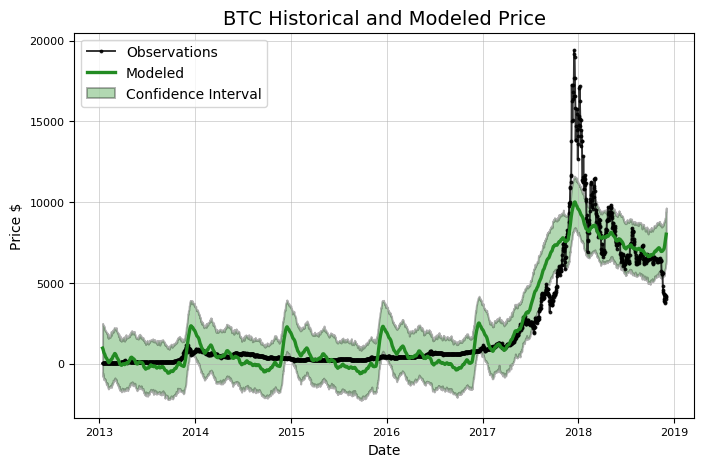

In [8]:
model, model_data = bitcoin.create_prophet_model()

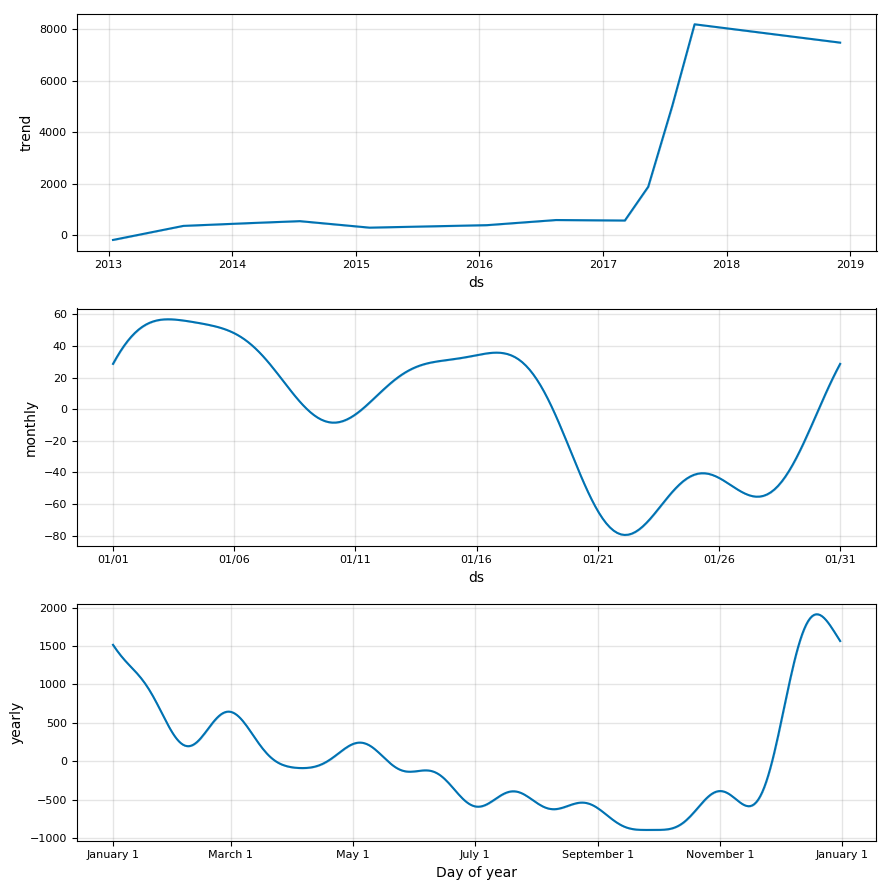

In [9]:
# Variables assigned from previous method call
model.plot_components(model_data)
plt.show()

### Test Addition of a Weekly Seasonality

Although it is unlikely, there might be a significant weekly component which would improve the model. Let's add it in and look at the pattern. 

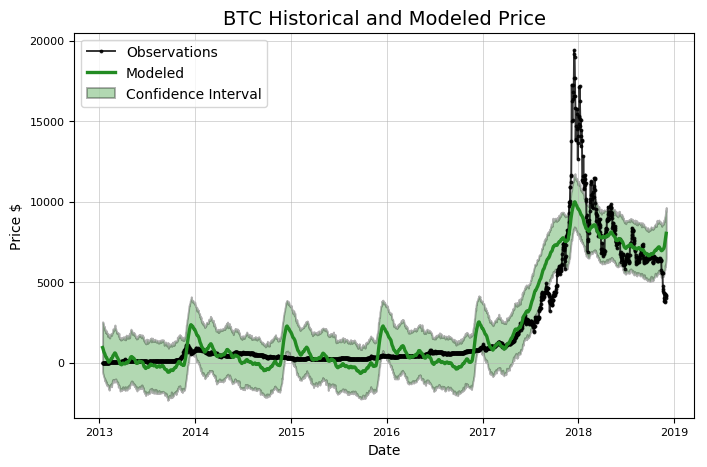

In [10]:
bitcoin.weekly_seasonality=True
model, model_data = bitcoin.create_prophet_model()

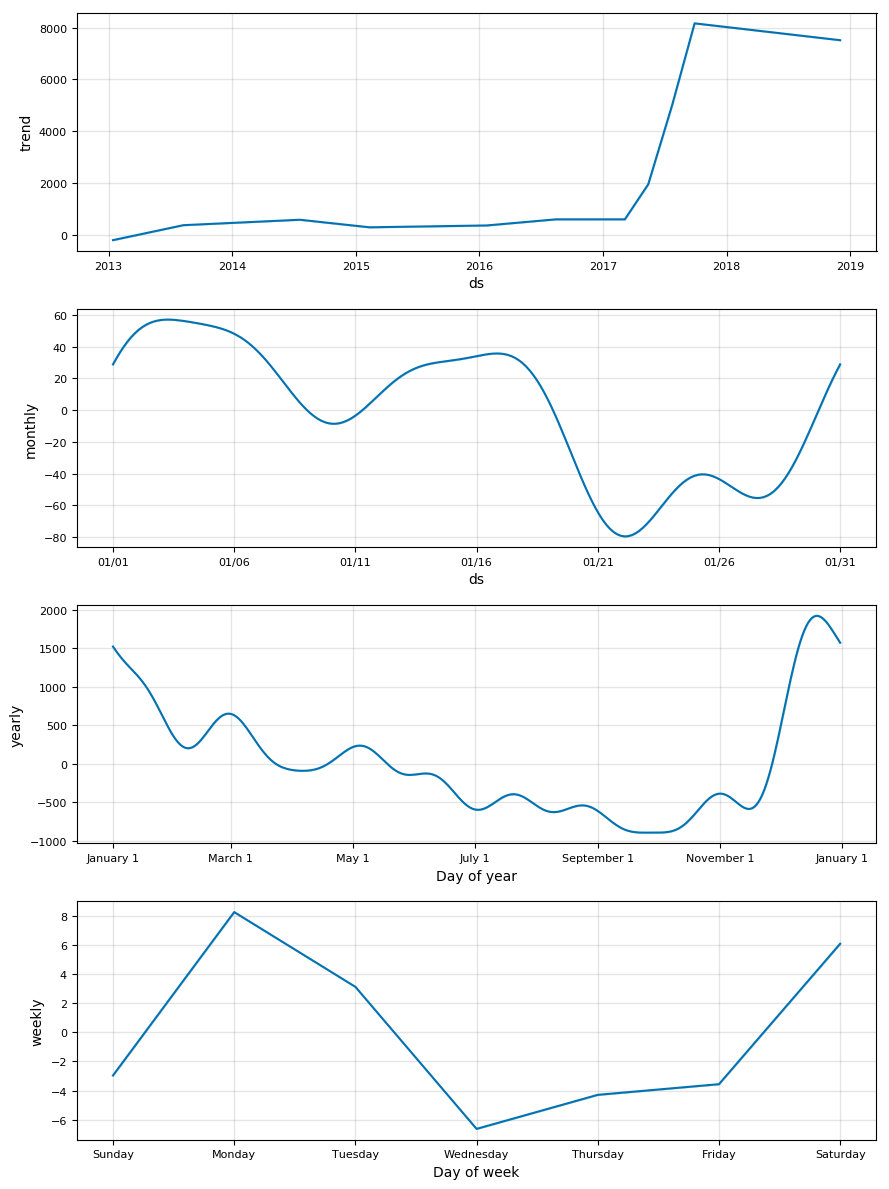

In [11]:
model.plot_components(model_data)
plt.show()

We will keep weekly seasonality as it looks like there is a dip on Wednesdays and spike on Saturdays.

# First Predictions

We can make a prediction for any number of specified days using the create model method. The prediction also includes the uncertainty interval, a necessity when making estimates about the future! 

Predicted Price on 2019-03-02 = $7973.29


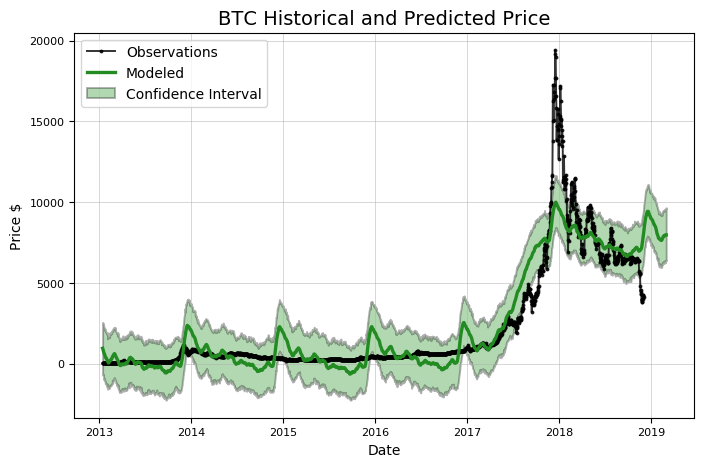

In [12]:
model, model_data = bitcoin.create_prophet_model(days=90)

# Evaluate Model

Anyone can make stock predictions by simply picking a number. For our predictions to be meaningful, we must evaluate them on real data. 

One way to do this is set aside some historical data as a test set and use data from further back as our training set. In the default evaluation method, we test using the past year and train on the 5 years prior to the test period. 

To quantify the accuracy of our predictions, we can find the average dollar error on both the testing and training data, the percentage the actual price was in the predicted confidence interval, and the percentage of times we predicted the correct direction for the stock. 


Prediction Range: 2017-12-02 to 2018-12-02.

Predicted price on 2018-12-01 = $14273.66.
Actual price on    2018-12-01 = $4188.15.

Average Absolute Error on Training Data = $140.40.
Average Absolute Error on Testing  Data = $3854.00.

When the model predicted an increase, the price increased 48.93% of the time.
When the model predicted a  decrease, the price decreased  40.54% of the time.

The actual value was within the 80% confidence interval 26.85% of the time.


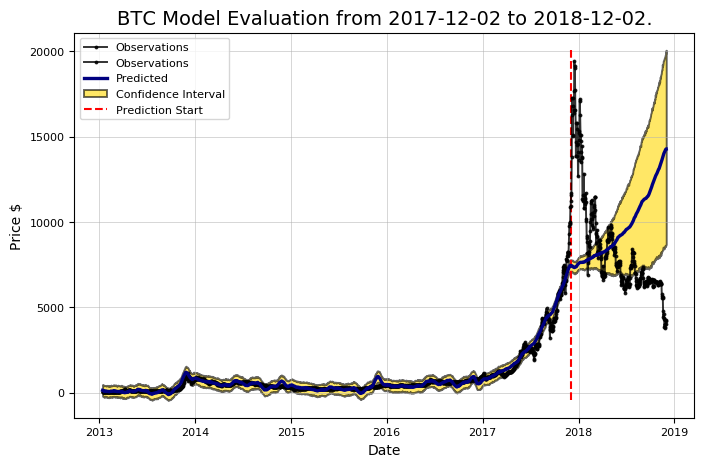

In [13]:
bitcoin.evaluate_prediction()

These predictions are not very good! However, it is likely that the model hyperparameters (settings) are not optimized for our problem. There are a number of these knobs we can adjust to improve the model, with perhaps the most important the changepoint prior scale, or the amount of weight the model assigns to shifts in the data.

# Changepoint Prior Scale Selection

Changepoints represent where a time series goes from increasing to decreasing or from increasing slowly to increasingly rapidly. They occur at the places with the [greatest change in the rate of the time series](https://facebook.github.io/prophet/docs/trend_changepoints.html). 

The changepoint prior scale represents the amount of weight given to the changepoints in the model. This can be used to control overfitting vs underfitting. A higher prior will create a model with more flexibility and more emphasis on the changepoints. This can lead to overfitting because the model will closely follow the training data. Lowering the prior decreases the model flexibility which can cause the opposite problem underfitting. This occurs when our model does not follow the training data closely enough and fails to learn the underlying relationships.

The Stocker class contains two different ways to choose an appropriate prior: grahically and quantitatively with validation data.

## Graphical Comparison

We will start with a range of four priors to compare. First, we can graphically compare them to get an intuition of how the priors affect the model.  

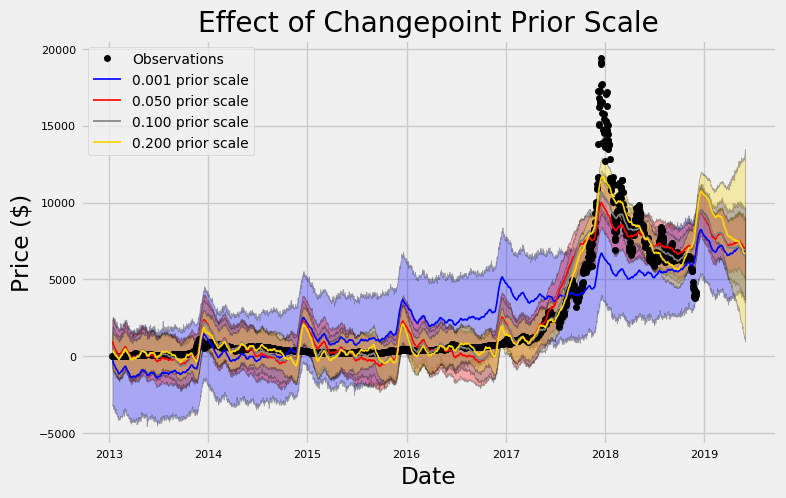

In [14]:
bitcoin.changepoint_prior_analysis(changepoint_priors=[0.001, 0.05, 0.1, 0.2])

## Quantitative Comparison

This gives us an idea of how well each prior fits the training data, but no numbers to back up our intuitions. The changepoint prior validation method is designed to provide numerical backing. We are testing from 2017-12-02 to 2018-12-02, so we need to make sure to use a different validation range. We will select two years prior to the testing date range. The model will be trained on the three years prior to the validation period.

/Users/lauramay/Documents/GitHub/crypto_signal/env/lib/python3.7/site-packages/pandas/core/frame.py:406: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  elif isinstance(data, collections.Iterator):



Validation Range 2016-12-02 to 2017-12-02.

     cps   train_err  train_range     test_err   test_range
0  0.001  155.741186   554.695168  2212.730430   554.074966
1  0.050   44.907478   164.198770  1865.088942   443.991777
2  0.100   32.379327   123.548466  1865.967919   979.375330
3  0.200   29.769107   114.858774  1900.879111  1264.588516


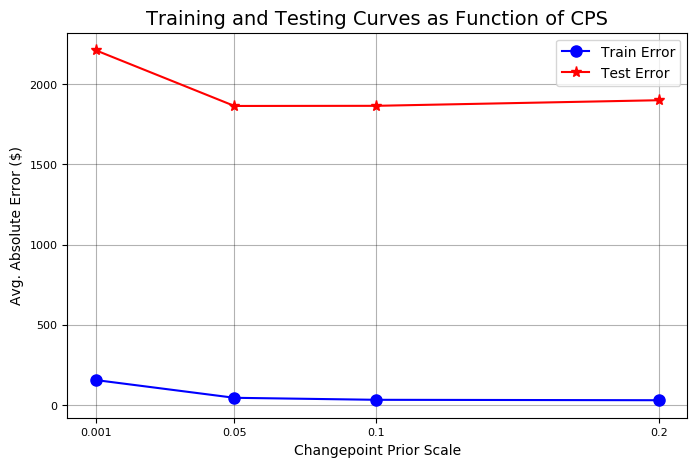

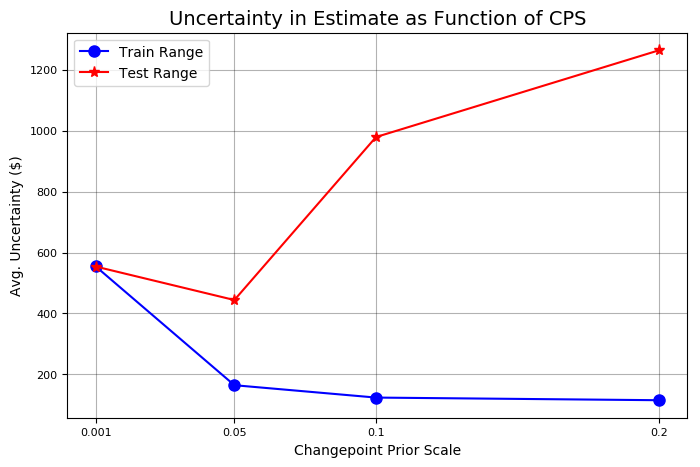

In [15]:
bitcoin.changepoint_prior_validation(changepoint_priors=[0.001, 0.05, 0.1, 0.2])

The test error decreases as we increase the prior. Like stocks, cryptocurrency exchange rates change considerably on a day to day basis, and a more flexible model can account for these fluctuations.

### Refine Search 

We can evaluate additional changepoint prior scales to determine the best fit for our data. 


Validation Range 2016-12-02 to 2017-12-02.

    cps  train_err  train_range     test_err   test_range
0  0.05  44.907478   164.063625  1865.088942   472.337871
1  0.15  30.092639   116.407964  1894.462750  1193.477317
2  0.20  29.769107   114.843515  1900.879111  1190.451881
3  0.40  28.600636   110.968264  1895.157811  1487.535042
4  0.50  28.025245   109.530097  1888.045180  1761.671754
5  0.60  27.772458   109.272400  1888.644811  1732.962725


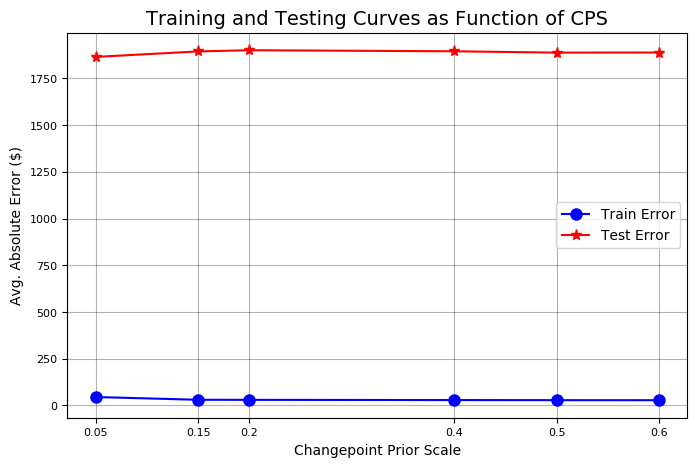

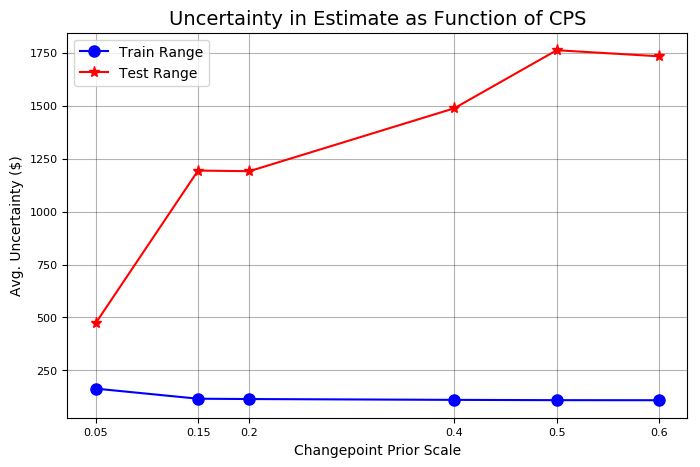

In [16]:
bitcoin.changepoint_prior_validation(changepoint_priors=[0.05, 0.15, 0.2, 0.4, 0.5, 0.6])

We now assign the changepoint prior with the smallest error on the testing set to the bitcoin object. The prior is one of the attiributes and we can change it like any other variable. At this point, we could also change the seasonalities or the amount of training data to achieve the best performance on the testing data

### Evaluate Improved Model

Evaluating model with 0.5 changepoint because it had the lowest test error and uncertainty range.


Prediction Range: 2017-12-02 to 2018-12-02.

Predicted price on 2018-12-01 = $14273.66.
Actual price on    2018-12-01 = $4188.15.

Average Absolute Error on Training Data = $140.40.
Average Absolute Error on Testing  Data = $3854.00.

When the model predicted an increase, the price increased 48.93% of the time.
When the model predicted a  decrease, the price decreased  40.54% of the time.

The actual value was within the 80% confidence interval 26.30% of the time.


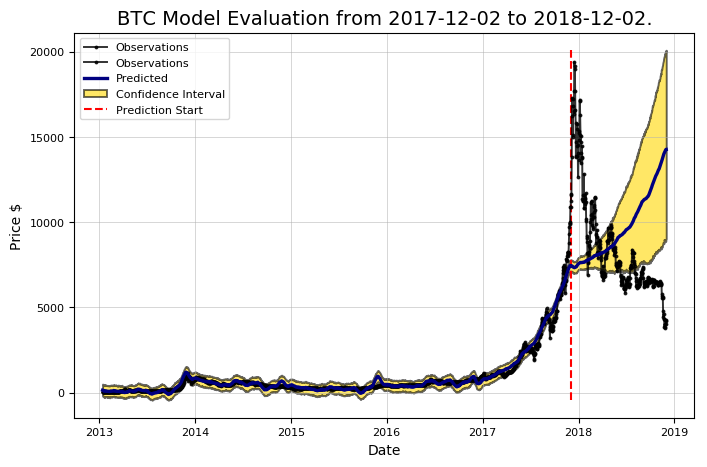

In [17]:
bitcoin.changepoint_prior_scale = 0.05
bitcoin.evaluate_prediction()

It looks like we have less than a 50/50 chance to predict a price increase or decrease. Also note that actuals are not within the confidence interval towards the end of 2018.

#### Evaluate higher changepoint
We are now going to try 0.4 changepoint because the absolute error is relatively similar, and for crypto_signal app we are trying to predict whether the price will increase or decrease, so we would like to get higher than 50% chance.


Prediction Range: 2017-12-02 to 2018-12-02.

Predicted price on 2018-12-01 = $16864.01.
Actual price on    2018-12-01 = $4188.15.

Average Absolute Error on Training Data = $118.34.
Average Absolute Error on Testing  Data = $4411.24.

When the model predicted an increase, the price increased 50.45% of the time.
When the model predicted a  decrease, the price decreased  55.17% of the time.

The actual value was within the 80% confidence interval 76.16% of the time.


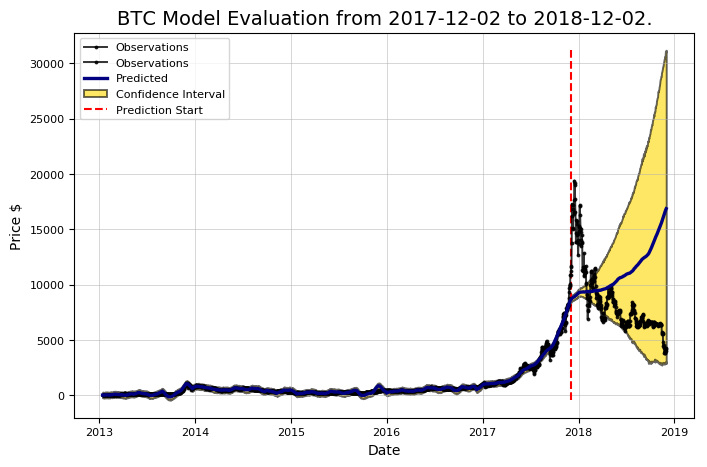

In [18]:
bitcoin.changepoint_prior_scale=0.4
bitcoin.evaluate_prediction()

We are deciding the best changepoint prior scale for our model is 0.4 because we are better predicting an increase/decrease (although not a great prediction!). We are also keeping all of the seasonality settings.

## Play the Daily Market

For fun (this should never be done for real) we can "play" the market with our predictions. We will compare our model with the simple strategy of buying and holding over the same time period. The rules of our game are straightforward:

1. If we predict the price will increase, we buy stock on that day. If we predict a decrease, we do not play the market.
2. If we predicted an increase and the stock does increase, we recieve the change in price of the stock over that day times the number of shares.
3. If we predicted an increase and the stock decreases, we lose the change in price of the stock over that day times the number of shares.

We are assuming the "change in price of a share on that day" is the difference between the previous days' closing price and the closing price on our day. For example, if the closing price on Monday was \$14 and the closing price on Tuesday was \$18, we would call that a \$4 change on Tuesday. This is not entirely accurate as stocks prices change a small amount overnight, but it will be acceptable for our game. Now, let's play with the defaults.

/Users/lauramay/Documents/GitHub/crypto_signal/crypto_signal/crypto_track/stocker.py:620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_pred_increase['pred_profit'] = prediction_profit


You played the stock market in BTC from 2017-12-02 to 2018-12-02 with 1000 shares.

When the model predicted an increase, the price increased 50.45% of the time.
When the model predicted a  decrease, the price decreased  55.17% of the time.

The total profit using the Prophet model = $-4583979.26.
The Buy and Hold strategy profit =         $-6728473.18.

Thanks for playing the stock market!



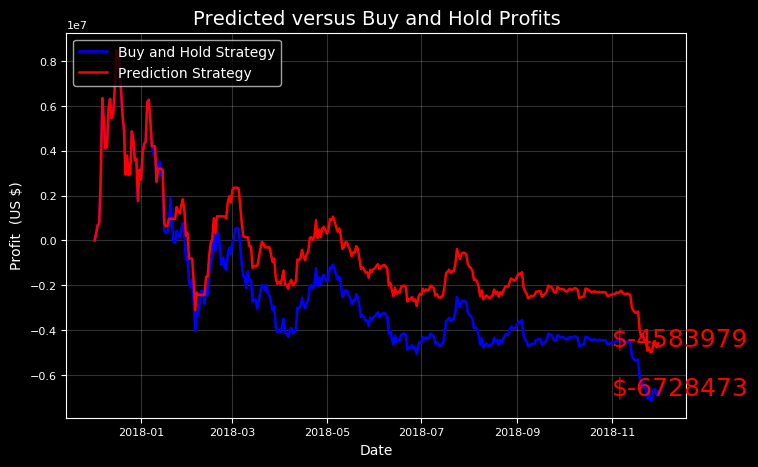

In [19]:
bitcoin.evaluate_prediction(nshares=1000)

Notice that our profits do not depend on the difference between the final predicted price and the actual price, only on the percentage of the time we correctly predicted the direction. We could alter the rules of the game to play it based on predicted values, but for now we can leave it at the rather simple exercise shown here. 

#### Try a Different Period

We can evaluate any time period we like to see if there are times when we beat the buy and hold strategy. More likely is that we will find times when we lose money. Nonetheless, it is important to test over different time frames to see how robust the model is to training data.

/Users/lauramay/Documents/GitHub/crypto_signal/crypto_signal/crypto_track/stocker.py:620: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_pred_increase['pred_profit'] = prediction_profit


You played the stock market in BTC from 2016-01-02 to 2017-12-01 with 1000 shares.

When the model predicted an increase, the price increased 54.91% of the time.
When the model predicted a  decrease, the price decreased  45.55% of the time.

The total profit using the Prophet model = $162963.12.
The Buy and Hold strategy profit =         $550800.70.

Thanks for playing the stock market!



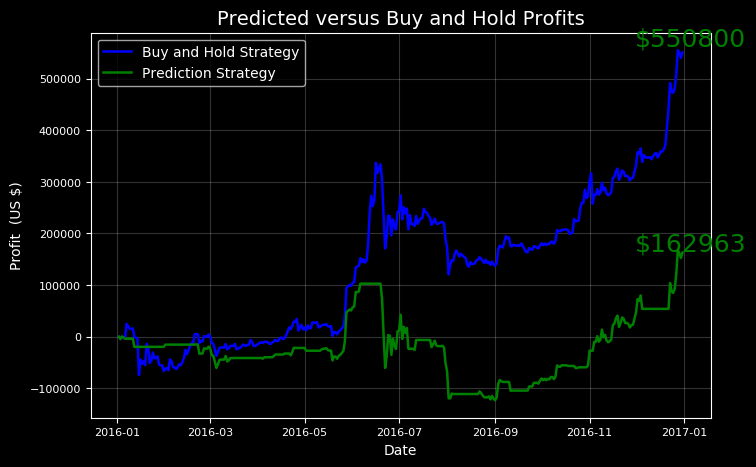

In [20]:
bitcoin.evaluate_prediction(start_date = '2016-01-02', end_date = '2017-12-01', nshares=1000)

# Predict the Future

As a last step, we can predict any number of days into the future. This function automatically trains on the past 3 years and makes predictions with the uncertainty intervals. 


Predicted Increase: 

           Date      estimate      change         upper        lower
2148 2018-12-02   9042.416208  195.600647  10154.172454  7845.572866
2149 2018-12-03   9274.335172  231.918964  10387.618431  8120.474869
2150 2018-12-04   9477.663886  203.328714  10582.768393  8367.885097
2151 2018-12-05   9657.877514  180.213628  10684.382232  8504.415869
2152 2018-12-06   9834.919962  177.042448  10896.101540  8787.988832
2153 2018-12-07  10001.271743  166.351781  11125.257180  8894.228806
2154 2018-12-08  10170.094063  168.822320  11302.370353  9108.116322
2155 2018-12-09  10310.023055  139.928992  11641.476059  9222.304317
2156 2018-12-10  10460.207825  150.184770  11518.052592  9392.208456
2157 2018-12-11  10574.155580  113.947755  11679.083290  9389.866741
2158 2018-12-12  10675.067401  100.911820  11879.137669  9531.855045

Predicted Decrease: 

Empty DataFrame
Columns: [Date, estimate, change, upper, lower]
Index: []


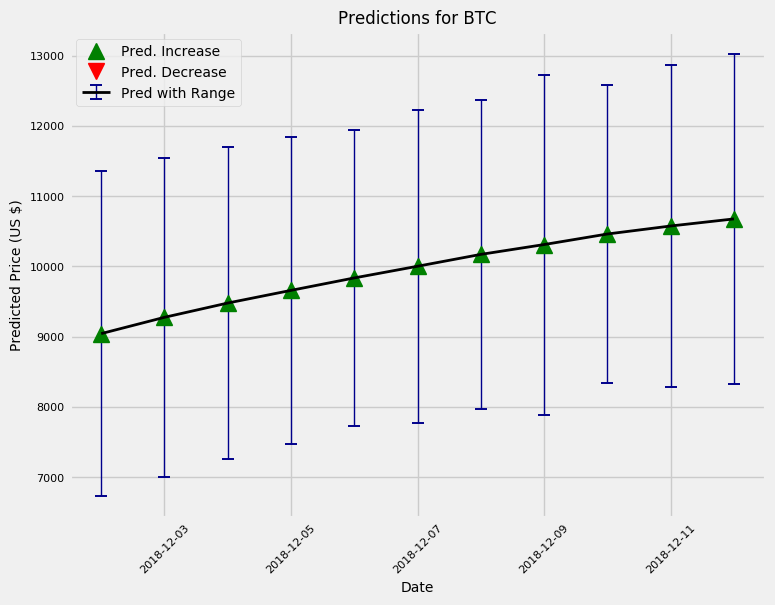

In [21]:
bitcoin.predict_future(days=10)


Predicted Increase: 

           Date      estimate      change         upper         lower
2148 2018-12-02   9042.416208  195.600647  10156.121050   7939.417947
2149 2018-12-03   9274.335172  231.918964  10376.626840   8115.566686
2150 2018-12-04   9477.663886  203.328714  10600.340785   8368.261615
2151 2018-12-05   9657.877514  180.213628  10764.696865   8463.665994
2152 2018-12-06   9834.919962  177.042448  10924.905433   8648.151609
2153 2018-12-07  10001.271743  166.351781  11149.972641   8930.313514
2154 2018-12-08  10170.094063  168.822320  11202.865472   9098.436137
2155 2018-12-09  10310.023055  139.928992  11511.406158   9196.227574
2156 2018-12-10  10460.207825  150.184770  11650.297765   9272.595941
2157 2018-12-11  10574.155580  113.947755  11707.812311   9388.410908
2158 2018-12-12  10675.067401  100.911820  11797.379220   9593.448738
2159 2018-12-13  10789.241588  114.174187  11963.464380   9696.120159
2160 2018-12-14  10902.868827  113.627239  12127.379475   9906.3306

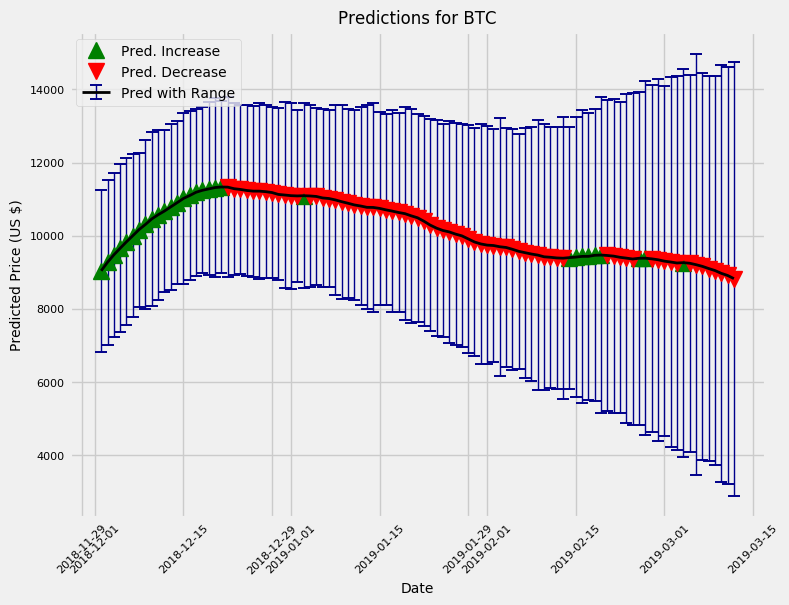

In [23]:
bitcoin.predict_future(days=100)

The uncertainty increases the farther out in the future we predict. This is to be expected because the initial forecasted values have some uncertainty, and the next values are made based on the previous ones, so the range of possible values grows over time. 

Whenever we make a prediction, we must be sure to include uncertainty intervals because there are no processes that can be exactly estimated in the future. While most people interpret a confidence interval as a lack of confidence, it really displays that we know the limitations of our model. 